## imports

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
pd.options.display.float_format = '{:.4f}'.format
from sklearn.metrics import  make_scorer, accuracy_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## methods

In [100]:
scoring = {"accuracy": make_scorer(accuracy_score),
           "ROC_AUC": make_scorer(roc_auc_score),
           "MSE": make_scorer(mean_squared_error)}

def get_scores(model, X_test, y_test, cv=5, scoring=scoring):
    scores = cross_validate(model, X_test, y_test, cv=cv, scoring=scoring)
    print("Accuracy: %.3f" % np.mean(scores["test_accuracy"]))
    print("ROC_AUC: %.3f" % np.mean(scores["test_ROC_AUC"]))
    print("MSE: %.3f" % np.mean(scores["test_MSE"]))

def get_plot(feature_importance, X_train):
    imps = pd.Series(feature_importance, index=X_train.columns)
    imps = imps.sort_values(ascending=True)

    sns.barplot(x=imps, y=imps.index)
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    

ordered_neigbours = ['JARDIM DA PENHA', 'MATA DA PRAIA', 'PONTAL DE CAMBURI', 'REPÚBLICA', 'GOIABEIRAS', 'ANDORINHAS', 'CONQUISTA', 'NOVA PALESTINA', 'DA PENHA',         'TABUAZEIRO', 'BENTO FERREIRA', 'SÃO PEDRO', 'SANTA MARTHA', 'SÃO CRISTÓVÃO',         'MARUÍPE', 'GRANDE VITÓRIA', 'SÃO BENEDITO', 'ILHA DAS CAIEIRAS',         'SANTO ANDRÉ', 'SOLON BORGES', 'BONFIM', 'JARDIM CAMBURI', 'MARIA ORTIZ',         'JABOUR', 'ANTÔNIO HONÓRIO', 'RESISTÊNCIA', 'ILHA DE SANTA MARIA',         'JUCUTUQUARA', 'MONTE BELO', 'MÁRIO CYPRESTE', 'SANTO ANTÔNIO', 'BELA VISTA',         'PRAIA DO SUÁ', 'SANTA HELENA', 'ITARARÉ', 'INHANGUETÁ', 'UNIVERSITÁRIO',         'SÃO JOSÉ', 'REDENÇÃO', 'SANTA CLARA', 'CENTRO', 'PARQUE MOSCOSO',         'DO MOSCOSO', 'SANTOS DUMONT', 'CARATOÍRA', 'ARIOVALDO FAVALESSA',         'ILHA DO FRADE', 'GURIGICA', 'JOANA D´ARC', 'CONSOLAÇÃO', 'PRAIA DO CANTO',         'BOA VISTA', 'MORADA DE CAMBURI', 'SANTA LUÍZA', 'SANTA LÚCIA',         'BARRO VERMELHO', 'ESTRELINHA', 'FORTE SÃO JOÃO', 'FONTE GRANDE',         'ENSEADA DO SUÁ', 'SANTOS REIS', 'PIEDADE', 'JESUS DE NAZARETH',         'SANTA TEREZA', 'CRUZAMENTO', 'ILHA DO PRÍNCIPE', 'ROMÃO', 'COMDUSA',         'SANTA CECÍLIA', 'VILA RUBIM', 'DE LOURDES', 'DO QUADRO', 'DO CABRAL', 'HORTO',         'SEGURANÇA DO LAR', 'ILHA DO BOI', 'FRADINHOS', 'NAZARETH', 'AEROPORTO', 'ILHAS OCEÂNICAS DE TRINDADE', 'PARQUE INDUSTRIAL']
neibours_to_int = {are: i for i, are in enumerate(ordered_neigbours)}

def get_region(n):
    for key, val in neibours_to_int.items():
        if key == n:
            return val
    return None

## Get the data

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [52]:
orig = pd.read_csv("noshows.csv")
orig

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0000,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438.0000,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951.0000,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174.0000,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183.0000,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0000,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3596266328735.0000,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,15576631729893.0000,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,92134931435557.0000,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [44]:
orig["No-show"].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

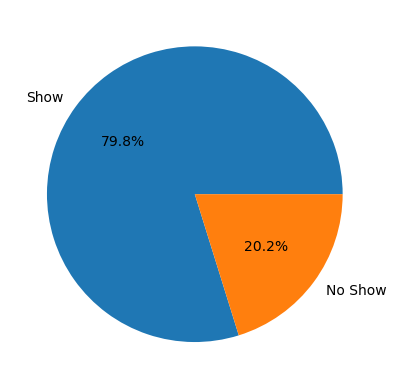

In [45]:
plt.pie(orig["No-show"].value_counts(), labels=["Show", "No Show"], autopct="%.01f%%")
plt.show()

In [46]:
df = orig

df["No-show"] = df["No-show"].map({"Yes":0, "No": 1})
df["Gender"] = df["Gender"].map({"M":0, "F": 1})


In [47]:
df["ScheduledDay"] = df["ScheduledDay"].astype('datetime64[ns]').dt.date
df["AppointmentDay"] = df["AppointmentDay"].astype('datetime64[ns]').dt.date

In [50]:
#wrong data - scheduling after appointment day

df[df["ScheduledDay"] > df["AppointmentDay"]]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
27033,7839272661752.0000,5679978,0,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,0
55226,7896293967868.0000,5715660,1,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,0
64175,24252258389979.0000,5664962,1,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,0
71533,998231581612122.0000,5686628,1,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,0
72362,3787481966821.0000,5655637,0,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,0


In [53]:
df = df[df["ScheduledDay"] <= df["AppointmentDay"]]

In [56]:
#create new column - the interval between ScheduledDay and AppointmentDay

(df["AppointmentDay"][0] - df["ScheduledDay"][0]).days

df["scheduled_days_before"] = (df["AppointmentDay"] - df["ScheduledDay"]).apply(lambda l: l.days)
df

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,scheduled_days_before
0,29872499824296.0000,5642903,1,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0
1,558997776694438.0000,5642503,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0
2,4262962299951.0000,5642549,1,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0
3,867951213174.0000,5642828,1,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0
4,8841186448183.0000,5642494,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0000,5651768,1,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,1,35
110523,3596266328735.0000,5650093,1,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,1,35
110524,15576631729893.0000,5630692,1,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,1,41
110525,92134931435557.0000,5630323,1,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,1,41


In [57]:
df["scheduled_days_before"].describe()

count   110522.0000
mean        10.1843
std         15.2551
min          0.0000
25%          0.0000
50%          4.0000
75%         15.0000
max        179.0000
Name: scheduled_days_before, dtype: float64

In [58]:
df.groupby("No-show")["Age", "Scholarship", "SMS_received","Hipertension","Diabetes","Alcoholism","Handcap","SMS_received","scheduled_days_before"].mean()

C:\Users\nadav\AppData\Local\Temp\ipykernel_5184\1439899884.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby("No-show")["Age", "Scholarship", "SMS_received","Hipertension","Diabetes","Alcoholism","Handcap","SMS_received","scheduled_days_before"].mean()


,Age,Scholarship,SMS_received,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,scheduled_days_before
No-show,,,,,,,,,
0,34.3179,0.1155,0.4385,0.1690,0.0641,0.0303,0.0202,0.4385,15.8355
1,37.7901,0.0939,0.2913,0.2044,0.0738,0.0304,0.0227,0.2913,8.7547


<AxesSubplot:>

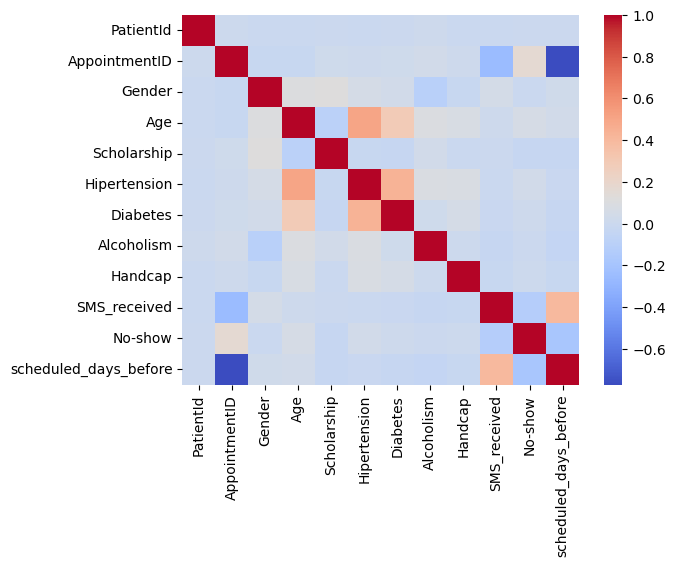

In [59]:
sns.heatmap(df.corr(), cmap="coolwarm")

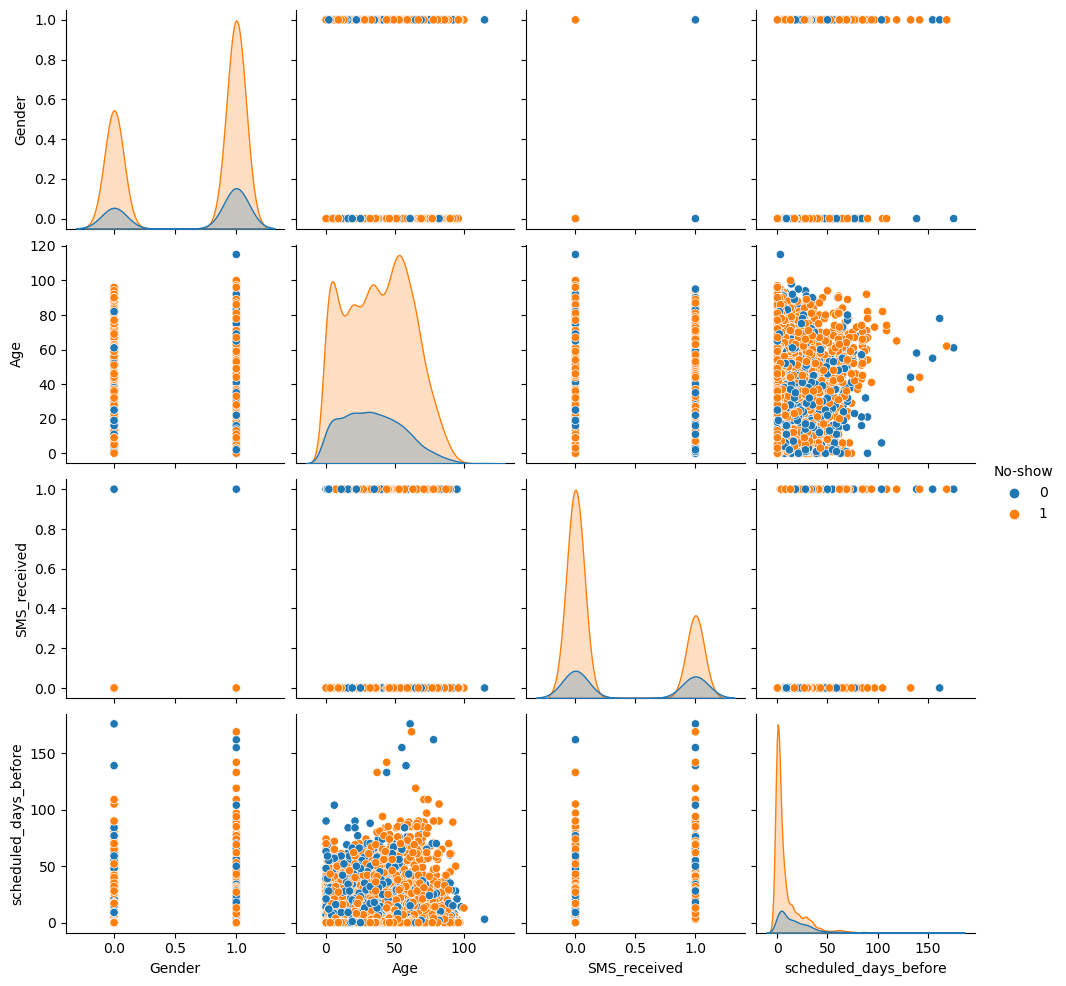

In [62]:
cols = ["Gender", "Age", "SMS_received", "scheduled_days_before"]
sns.pairplot(df.sample(10000), vars=cols, hue="No-show")
plt.show()

In [11]:
# # dfg = df.groupby('Neighbourhood')['PatientId'].count().reset_index(name="count")
# # dfg[dfg['count'] > 1000]
# # df['']
# dfg = df.groupby('Neighbourhood').filter(lambda x: len(x) > 1000)
# dfg.plot(kind='bar')
# #plt.xlabel('Neighbourhood')
# #plt.ylabel('Count')
# #plt.title('Appointments by Neighbourhood')
# plt.show()
  


In [68]:


# df["Neighbourhood"] = df["Neighbourhood"].apply(get_region)

In [69]:
df

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,scheduled_days_before
0,29872499824296.0000,5642903,1,2016-04-29,2016-04-29,62,None,0,1,0,0,0,0,1,0
1,558997776694438.0000,5642503,0,2016-04-29,2016-04-29,56,None,0,0,0,0,0,0,1,0
2,4262962299951.0000,5642549,1,2016-04-29,2016-04-29,62,None,0,0,0,0,0,0,1,0
3,867951213174.0000,5642828,1,2016-04-29,2016-04-29,8,None,0,0,0,0,0,0,1,0
4,8841186448183.0000,5642494,1,2016-04-29,2016-04-29,56,None,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0000,5651768,1,2016-05-03,2016-06-07,56,None,0,0,0,0,0,1,1,35
110523,3596266328735.0000,5650093,1,2016-05-03,2016-06-07,51,None,0,0,0,0,0,1,1,35
110524,15576631729893.0000,5630692,1,2016-04-27,2016-06-07,21,None,0,0,0,0,0,1,1,41
110525,92134931435557.0000,5630323,1,2016-04-27,2016-06-07,38,None,0,0,0,0,0,1,1,41


In [63]:
drop_cols = [ "PatientId", "AppointmentID", "ScheduledDay", "AppointmentDay"]
df_final = df.drop(drop_cols, axis=1)

In [64]:
df_final

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,scheduled_days_before
0,1,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0
1,0,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0
2,1,62,MATA DA PRAIA,0,0,0,0,0,0,1,0
3,1,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0
4,1,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
110522,1,56,MARIA ORTIZ,0,0,0,0,0,1,1,35
110523,1,51,MARIA ORTIZ,0,0,0,0,0,1,1,35
110524,1,21,MARIA ORTIZ,0,0,0,0,0,1,1,41
110525,1,38,MARIA ORTIZ,0,0,0,0,0,1,1,41


(0.0, 100.0)

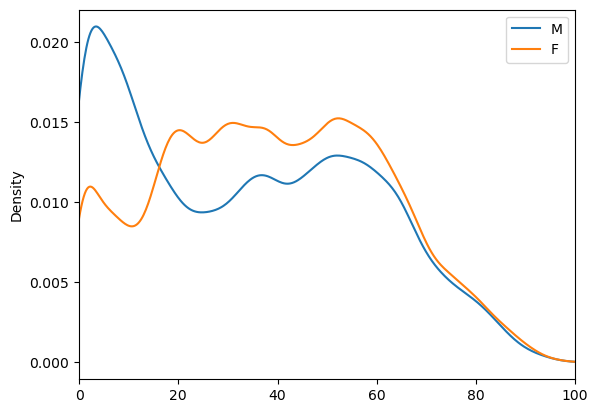

In [15]:
df.groupby('Gender').Age.plot(kind='kde' )
plt.legend(["M","F"])
plt.xlim([0, 100])

<AxesSubplot:ylabel='Density'>

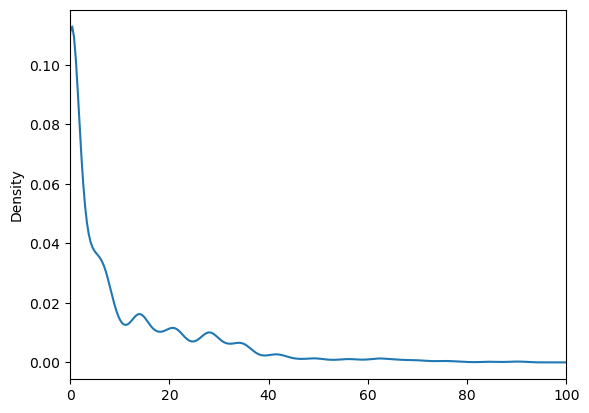

In [16]:
plt.xlim([0, 100])
df.scheduled_days_before.plot(kind='kde' )

In [79]:
df_final = df_final.drop("Neighbourhood", axis=1)
X = df_final.drop("No-show", axis=1)

y = df["No-show"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)
print(len(X_train), len(X_test))

33156 77366


Accuracy: 0.788
ROC_AUC: 0.531
MSE: 0.212


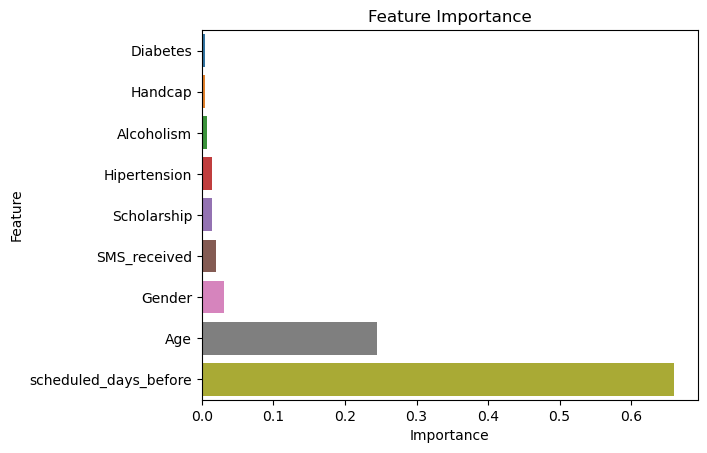

In [111]:
random_state = 124
min_samples_leaf = 25

model_1 = DecisionTreeClassifier(random_state=random_state, min_samples_leaf=min_samples_leaf)
model_1.fit(X_train, y_train)
model_1.score(X_test, y_test)
get_scores(model_1, X_test, y_test)
get_plot(model_1.feature_importances_, X_train)

Accuracy: 0.795
ROC_AUC: 0.505
MSE: 0.205


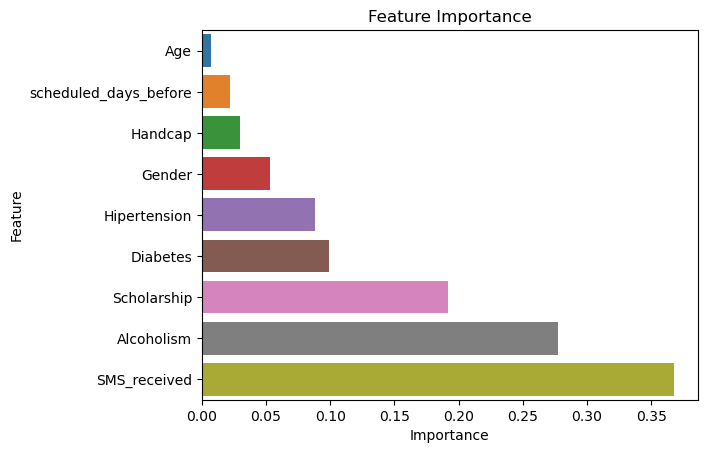

In [104]:
model_2 = LogisticRegression()
model_2.fit(X_train, y_train)
model_2.score(X_test, y_test)
coefficients = model_2.coef_
avg_importance = np.mean(np.abs(coefficients), axis=0)
get_scores(model_2, X_test, y_test)
get_plot(avg_importance, X_train)


In [110]:
model_3 = KNeighborsClassifier()
model_3.fit(X_train, y_train)
model_3.score(X_test, y_test)
get_scores(model_3, X_test, y_test)


Accuracy: 0.768
ROC_AUC: 0.545
MSE: 0.232


In [25]:
def my_experiment_function(df1, list_of_features, my_model):
  df_train, df_test = train_test_split(df1, random_state=1, test_size=0.2)

  X_train, y_train = df_train[list_of_features],df_train["No-show"]
  X_test, y_test = df_test[list_of_features],df_test["No-show"]
  
  my_model.fit(X_train, y_train)

  y_pred = my_model.predict(X_test)
  score = my_model.score(X_test, y_test)
  return score

list_of_features = ["Gender", "Age","scheduled_days_before","SMS_received"]
score = my_experiment_function(df, list_of_features, LogisticRegression())
print(score)

score = my_experiment_function(df, list_of_features, DecisionTreeClassifier())
print(score)

score = my_experiment_function(df, list_of_features, RandomForestClassifier())
print(score)

score = my_experiment_function(df, list_of_features, SVC())
print(score)

score = my_experiment_function(df, list_of_features, KNeighborsClassifier())
print(score)


0.7966163032660816
0.7615579480683977
0.773862299828101
0.8002352302542296


c:\Users\nadav\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\nadav\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.7608341626707681


In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.31      0.02      0.03      4416
           1       0.80      0.99      0.89     17690

    accuracy                           0.80     22106
   macro avg       0.56      0.50      0.46     22106
weighted avg       0.70      0.80      0.72     22106



In [28]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X_train, y_train, cv=5, scoring = "neg_mean_squared_error").mean()

-0.205799533378265

In [29]:
cross_val_score(model, X_train, y_train, cv=5, scoring = "neg_mean_squared_error")

array([-0.20525869, -0.20645781, -0.20651436, -0.20532685, -0.20543995])